In [7]:
#General Python Stuff
import os
import numpy as np
from matplotlib import pyplot as plt

#Torch Stuff
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.nn import MSELoss, BCELoss
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

#Metrics
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

#Progress Bar
from tqdm import tqdm

#Image Manipulation Stuff
from PIL import Image
from albumentations import Compose, OneOf, Flip, Resize, RandomCrop, CenterCrop
import cv2

#Imported files
from VOCDataset import VOCDataset
from BSD300Dataset import BSD300
from SRGAN import Generator, Discriminator
from Generator_Loss import GeneratorLoss

#Load the Data
batch_size=1
bsd_root = '../Data/BSD300/images'
dataset = BSD300(bsd_root)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#Cuda
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Save paths for models to test
generator_save_pth = '../Data/Model Saves/Generator_V2_2.pth'
discriminator_save_pth = '../Data/Model Saves/Discriminator_V2_2.pth'

#Load in generator and discriminator
generator = Generator(4).to(cuda)
generator.load_state_dict(torch.load(generator_save_pth))
generator.eval()
discriminator = Discriminator().to(cuda)
discriminator.load_state_dict(torch.load(discriminator_save_pth))
discriminator.eval()

#Initialize loss functions
loss_gen = GeneratorLoss(cuda)
loss_disc = BCELoss().to(cuda)
mse_loss = MSELoss().to(cuda)

#Arrays for saving metrics
hr_im_score = []
sr_im_score = []
disc_loss = []
gen_loss = []
ssim_sr = []
psnr_sr = []
mse_sr = []
ssim_cubic = []
psnr_cubic = []
mse_cubic = []

test_bar = tqdm(dataloader) #Set up Progress Bar
with torch.no_grad(): #Because eval
    for hr, lr in test_bar: #Get images
        
        #Cubic upscale the low-res image for comparison
        lr_for_cubic = lr.permute(0,2,3,1).numpy()[0]
        cubic = cv2.resize(lr_for_cubic, (4*lr_for_cubic.shape[1], 4*lr_for_cubic.shape[0]), interpolation=cv2.INTER_CUBIC)
        cubic = torch.unsqueeze(torch.from_numpy(cubic).permute(2,0,1), 0).to(cuda)
        
        #Send images to cuda
        lr = lr.to(cuda)
        hr = hr.to(cuda)
        
        #Use model to get SR Image
        sr = generator(lr)
        
        #Get Discriminator scores for original and SR image
        hr_score = discriminator(hr)
        sr_score = discriminator(sr)
        
        #Discriminator loss
        disc_loss_hr = loss_disc(discriminator(hr), torch.full((hr.shape[0],), 1, dtype=lr.dtype, device=cuda))
        disc_loss_sr = loss_disc(discriminator(sr), torch.full((sr.shape[0],), 0, dtype=lr.dtype, device=cuda))
        _disc_loss = disc_loss_hr+disc_loss_sr
        
        #Generator & MSE loss
        gen_loss_weights = [0, 1e-3, 1, 1e-8]
        _gen_loss = loss_gen(sr_score, sr, hr, gen_loss_weights)
        loss_mse_sr = mse_loss(sr,hr)
        loss_mse_cubic = mse_loss(cubic, hr)
        
        #PSNR/SSIM Scores
        hr = hr.permute(0,2,3,1).to('cpu').detach().numpy()
        sr = sr.permute(0,2,3,1).to('cpu').detach().numpy()
        cubic = cubic.permute(0,2,3,1).to('cpu').detach().numpy()
        ssim_sr.append(ssim(hr[0], sr[0], multichannel=True))
        psnr_sr.append(psnr(hr, sr))
        ssim_cubic.append(ssim(hr[0], cubic[0], multichannel=True))
        psnr_cubic.append(psnr(hr, cubic))
        
        #Save the metrics
        hr_im_score.append(hr_score.cpu().detach().numpy())
        sr_im_score.append(sr_score.cpu().detach().numpy())
        disc_loss.append(_disc_loss.cpu().detach().numpy()) 
        gen_loss.append(_gen_loss.cpu().detach().numpy())
        mse_sr.append(loss_mse_sr.cpu().detach().numpy())
        mse_cubic.append(loss_mse_cubic.cpu().detach().numpy())

#Print results
print('====================== TEST DATASET RESULTS ======================')
print('HR Image Score: {}'.format(np.average(hr_im_score)))
print('SR Image Score: {}'.format(np.average(sr_im_score)))
print('Discriminator Loss: {}'.format(np.average(disc_loss)))
print('Generator Loss: {}'.format(np.average(gen_loss)))
print('SR PSNR: {}'.format(np.average(psnr_sr)))
print('SR SSIM: {}'.format(np.average(ssim_sr)))
print('SR MSE: {}'.format(np.average(mse_sr)))
print('Cubic PSNR: {}'.format(np.average(psnr_cubic)))
print('Cubic SSIM: {}'.format(np.average(ssim_cubic)))
print('Cubic MSE: {}'.format(np.average(mse_cubic)))


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:56<00:00,  2.57it/s]

====================== TEST DATASET RESULTS ======================
HR Image Score: 0.2542206943035126
SR Image Score: 0.3824455440044403
Discriminator Loss: 2.820392370223999
Generator Loss: 0.31568655371665955
SR PSNR: 23.862483855330844
SR SSIM: 0.7562800955740971
SR MSE: 0.005367244128137827
Cubic PSNR: 23.5906599933238
Cubic SSIM: 0.7666968412898293
Cubic MSE: 0.0058402628637850285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SR SSIM: 0.8957364492074517
SR PSNR: 30.18350228075677
Cubic SSIM: 0.8974440364138524
Cubic PSNR: 29.97275941002333


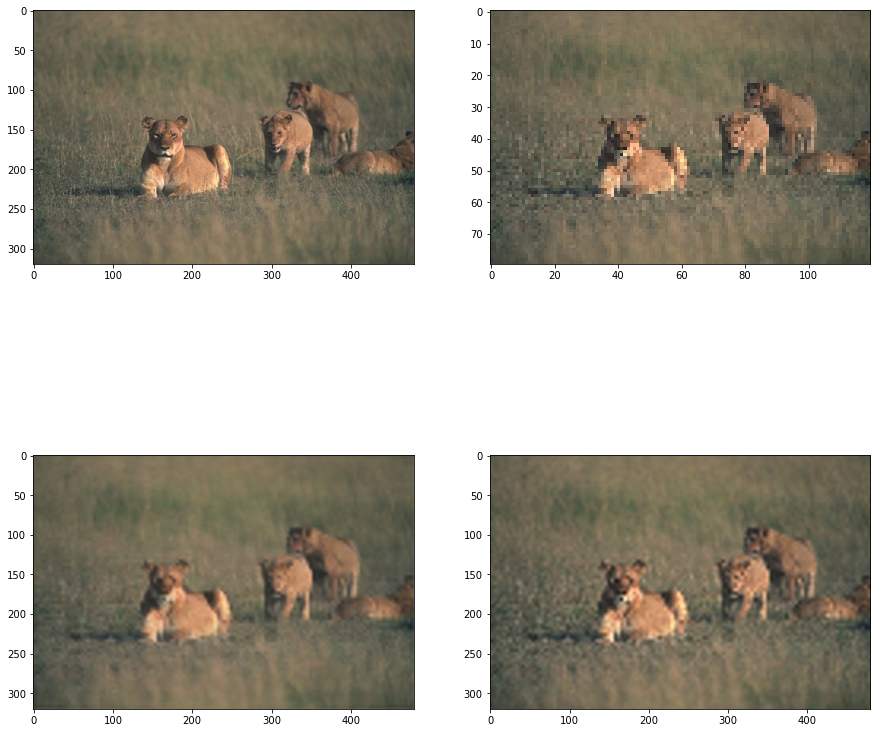

In [14]:
#For getting 1 image at a time
dataiter = iter(dataset)

#Get SR image
with torch.no_grad():
    hr_im, lr_im = next(dataiter)
    sr_im = generator(torch.unsqueeze(lr_im,0).to(cuda))

#Plot original and downscaled image
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
ax[0,0].imshow(hr_im.permute(1,2,0).numpy())
ax[0,1].imshow(lr_im.permute(1,2,0).to('cpu').detach().numpy())

#Plot the SR image
im = sr_im[0].permute(1,2,0).to('cpu').detach().numpy()
ax[1,0].imshow(im)

#SR Image metrics
print("SR SSIM: " + str(ssim(hr_im.permute(1,2,0).numpy(), im, multichannel=True)))
print("SR PSNR: " + str(psnr(hr_im.permute(1,2,0).numpy(), im)))

#Get and plot cubic upscale image for comparison
lr_im = lr_im.permute(1,2,0).to('cpu').detach().numpy()
cubic_im = cv2.resize(lr_im, (4*lr_im.shape[1], 4*lr_im.shape[0]), interpolation=cv2.INTER_CUBIC)
ax[1,1].imshow(cubic_im)

#Cubic upscale image metrics for comparison
print("Cubic SSIM: " + str(ssim(hr_im.permute(1,2,0).numpy(), cubic_im, multichannel=True)))
print("Cubic PSNR: " + str(psnr(hr_im.permute(1,2,0).numpy(), cubic_im)))